# Support Vector Machines

## Author : Vincent HERFELD

In [3]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

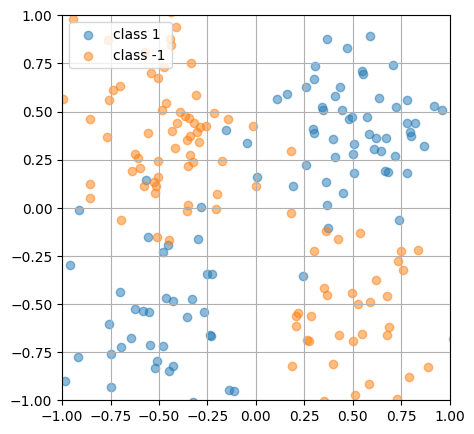

In [4]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)


## I- Kernel SVC 

### 0 - Questions 
We recall the problem of the kernel SVM (in standard form):


\begin{align*}
\underset{f, b, (\xi_i)_i}{\min} \frac{1}{2}||f||^2 &+ C\sum_{i=1}^{n} \xi_i \\
\textbf{s.t.  } \forall i \in \{1,...,n\} \;\; -y_i(f(x_i) + b) &\leq \xi_i - 1 \\
                                                           -\xi_i  &\leq 0
\end{align*}


We note that $f$ belongs to a RKHS and we call $K$ the associated kernel.


a) Let's write the Lagrangian associated to the kernel SVM problem : (we introduce $\alpha = (\alpha_i)_i$ and $\mu = (\mu_i)_i$ as Lagrangian multipliers)


\begin{align*}
L(f, b, \xi, \mu, \nu) = \frac{1}{2}||f||^2 &+ C\sum_{i=1}^{n} \xi_i - \sum_{i=1}^{n} \alpha_i(y_i(f(x_i) + b) + \xi_i - 1) - \sum_{i=1}^{n} \mu_i\xi_i
\end{align*}


b) Since the problem above is a convex problem (convex objective and affine constraints on $f$, $b$ and $\xi$), we can use the condition on the gradient of the Lagragian for optimality ie : $(f^*, b^*, \xi^*)$ is an optimal point for the problem $\underset{f, b, (\xi_i)_i}{\min} L(f, b, \xi, \mu, \nu)$,  if $\nabla_{f,b,\xi} L(f^*, b^*, \xi^*, \mu, \nu) = 0$.

Let's compute the gradients :  

\begin{align*}
\nabla_{f} L(f, b, \xi, \alpha, \mu) &= f - \sum_{i=1}^{n}\alpha_iy_iK_{x_i} = 0 \Leftrightarrow f = \sum_{i=1}^{n}\alpha_iy_iK_{x_i}\\
\nabla_{b} L(f, b, \xi, \alpha, \mu) &= -C\sum_{i=1}^{n}\alpha_iy_i = 0 \Leftrightarrow C\sum_{i=1}^{n}\alpha_iy_i = 0\\
\nabla_{\xi} L(f, b, \xi, \alpha, \mu) &= C\mathbf{1}_n - \alpha - \mu = 0 \Leftrightarrow \alpha + \mu = C\mathbf{1}_n
\end{align*}


We can express the dual : 


\begin{align*}
g(\alpha, \nu) = \underset{f, b, \xi}{\inf}\; L(f, b, \xi, \alpha, \mu) = 
\begin{dcases*}
-\frac{1}{2}\alpha^T \text{diag}(y)K\text{diag}(y)\alpha + \alpha^T\mathbf{1}_n & if $y^T\alpha= 0$ and $\alpha + \mu = C\mathbf{1}_n$ \\
-\infty & otherwise
\end{dcases*}
\end{align*}


We note $K = (K(x_i, x_j))_{i,j \in \{1,...,n\}}$

Since we want to maximise the dual objective we add as constraints the conditions for $g > -\infty$ the dual problem is thus :


\begin{align*}
\underset{\alpha, \mu}{\max} -\frac{1}{2}\alpha^T \text{diag}(y)K&\text{diag}(y)\alpha + \alpha^T\mathbf{1}_n\\
\textbf{s.t.  }  y^T\alpha &= 0\\
                 \alpha + \mu &= C\mathbf{1}_n\\
                 \alpha \succeq 0, \mu &\succeq 0
\end{align*}


Using the condition $\mu \succeq 0$ and since the objective only depends on $\alpha$ we can actually combine the condition for $\alpha + \mu = C\mathbf{1}_n$ and write $\alpha \preceq C\mathbf{1}_n$. We rewrite the dual : 


\begin{align*}
\underset{\alpha}{\max} -\frac{1}{2}\alpha^T \text{diag}(y)K&\text{diag}(y)\alpha + \alpha^T\mathbf{1}_n\\
\textbf{s.t.  }  y^T\alpha &= 0\\
                0 \preceq \alpha &\preceq C\mathbf{1}_n\\
\end{align*}



c) Strong duality tells us that the minimal value of the primal is equal to the maximum value of the dual (ie the duality gap is 0). So once we solve the dual we can use the previous relationship given by the primal, $f^* = \sum_{i=1}^{n}\alpha^*_iy_iK_{x_i}$, to obtain a partial solution to the primal.

Complimentary slackness condition gives us : $\forall j, \; -\mu_j\xi_j = 0 \Leftrightarrow \forall j, \; (\alpha^*_j - C)\xi_j = 0$ and $\forall j, \; \alpha^*_i(y_i(f^*(x_i) + b) + \xi_i - 1) = 0 \Leftrightarrow \forall j, \; \alpha_j(y_j(\sum_{i=1}^{n}\alpha^*_iy_iK(x_i, x_j) + b) + \xi_j - 1) = 0$.

Let us now consider the points $(x_i)_I$ that verify $y_i(f^*(x_i) + b) = 1 \Leftrightarrow y_i(\sum_{j=1}^{n}\alpha^*_jy_jK(x_j, x_i) + b) = 1$ this gives us by plugging this condition in the previous relationships, $\forall i \in I, \; \alpha^*_i\xi_i = 0$ and thus :


\begin{align*}
\forall i \in I, \xi_i = 0
\end{align*}


By looking at the course slides we identify a characterization of the support vectors (elements of index in $I$) that is :


\begin{align*}
I = \{i \in \{1,...,n\}, 0 < \alpha_i < C\}
\end{align*}


This done we know that the solution is fully characterized by points of index in $I$, thus we can find :


\begin{align*}
b &= \frac{1}{y_i} - f^*(x_i) = y_i - f^*(x_i)\; \forall i \in I\\
\end{align*}


### 1- Implementing the Gaussian and linear kernels

Implement the method 'kernel' of the classes RBF and Linear below. The RBF kernel which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_i\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

To compute the kernel we will use a classical result on the squared euclidian norm.

In [5]:
X = dataset['train']['x']
y = dataset['train']['y']

In [6]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        distances = np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    
        K = np.exp(-distances / (2 * sigma**2))
    
        return K

In [7]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        prod = X[:, None] * Y[None,:]
        return np.sum(prod, axis=-1)## Matrix of shape NxM


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [8]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        self.K = self.kernel(X, X)
        self.X = X
        self.y = y
        # Lagrange dual problem
        def loss(alpha):
            return -0.5 * alpha.T @ np.diag(y) @ self.K @ np.diag(y) @ alpha + np.sum(alpha)

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return -np.diag(y) @ self.K @ np.diag(y) @ alpha + np.ones(N)


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: y.T @ alpha       
        jac_eq = lambda alpha: y
        fun_ineq = lambda alpha: np.concatenate((alpha, self.C - alpha))
        jac_ineq = lambda alpha: np.concatenate((np.eye(N), -np.eye(N)))
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: -loss(alpha), #we minimize the opposite
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: -grad_loss(alpha), 
                                   constraints=constraints) 
        self.alpha = optRes.x

        self.beta = np.diag(self.y) @ self.alpha #such that f(x) = sum_i beta_i K(x_i,x)
        
        ## Assign the required attributes
        self.margin_indices = (self.epsilon < self.alpha) & (self.alpha < self.C) #np.where(self.epsilon < self.alpha & self.alpha < C, True, False)
        self.support = X[self.margin_indices]
        f = self.K @ self.beta
        self.b = np.mean(y[self.margin_indices] - f[self.margin_indices])
        self.norm_f = self.beta.T @ self.K @ self.beta


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x, self.support)
        return K @ self.beta[self.margin_indices]
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d + self.b > 0) - 1

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

### Dataset 1
#### Linear classifier

Number of support vectors = 15


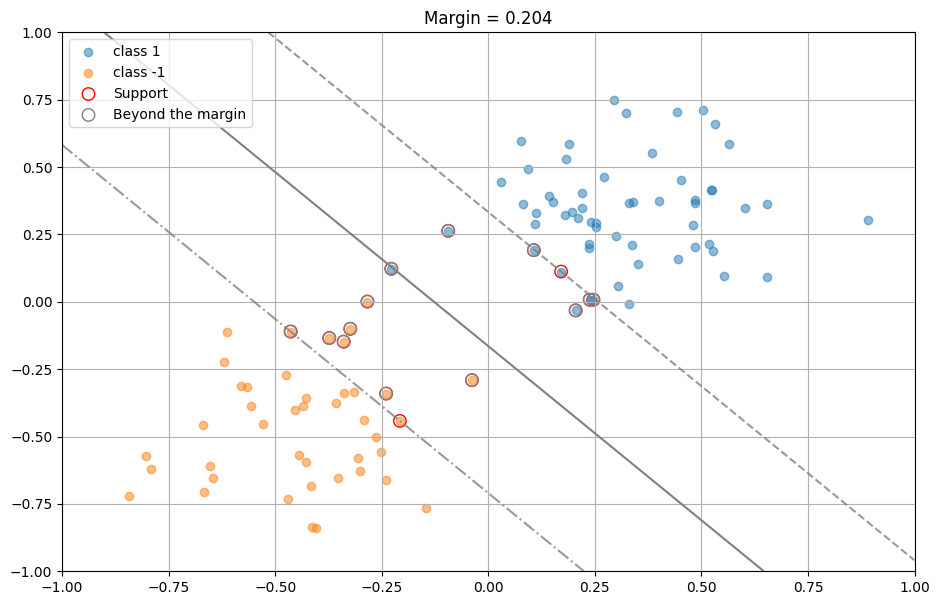

In [9]:
C= 1#TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian classifier

Number of support vectors = 11


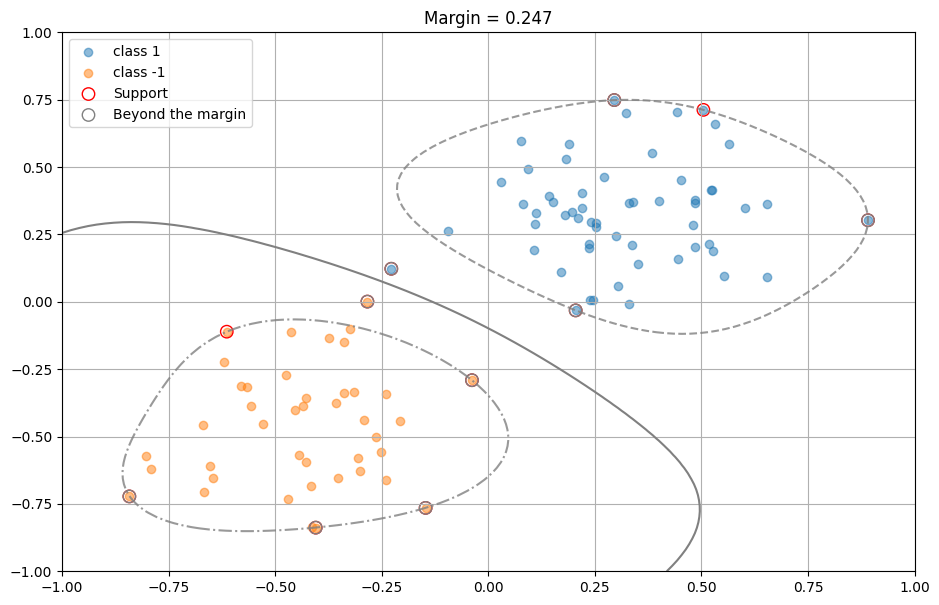

In [10]:
sigma = 0.35#TODO: provide a reasonalbe value
C= 3#TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-13)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 2
#### Linear SVM

Number of support vectors = 38


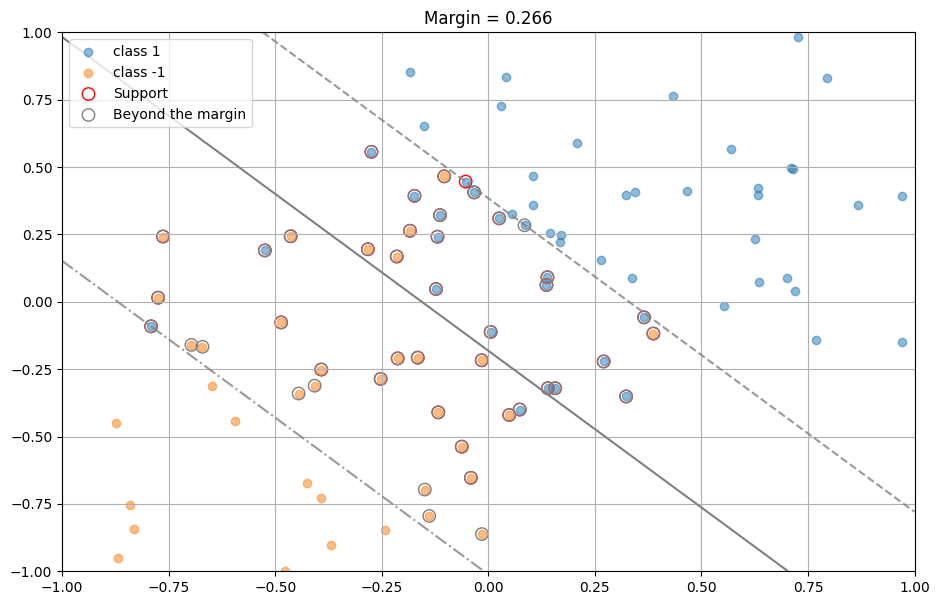

In [11]:
C= 2#TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-13)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 39


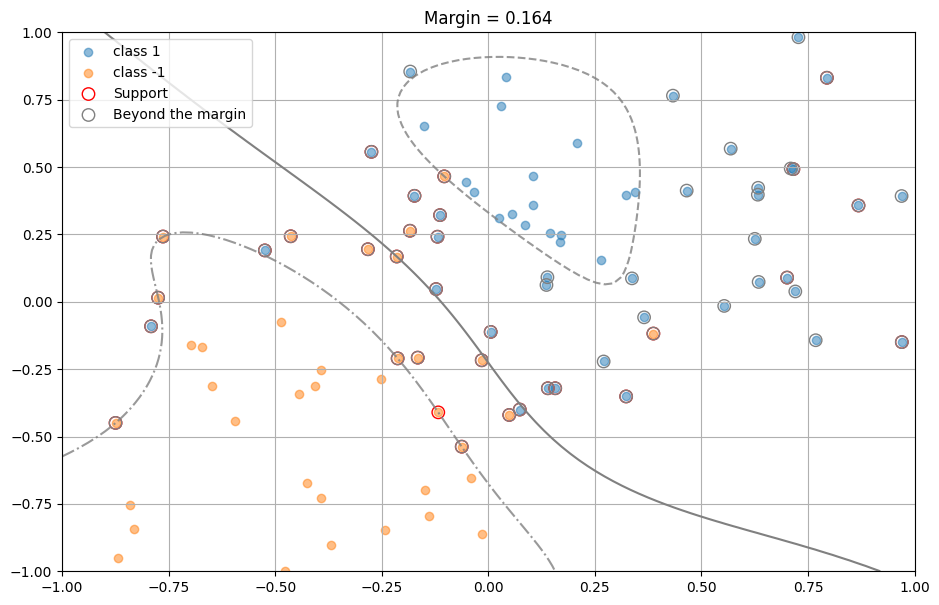

In [12]:
sigma = 0.4#TODO: provide a reasonalbe value
C= 2 #TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-13)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

### Dataset 3
#### Linear SVM

Number of support vectors = 186


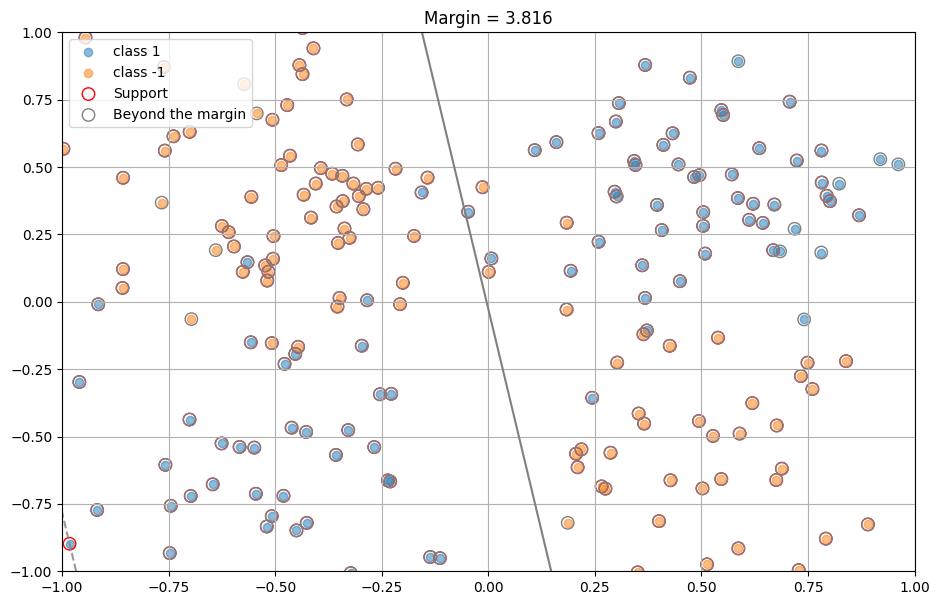

In [13]:
C= 1#TODO: provide a reasonable value
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Gaussian SVM

Number of support vectors = 58


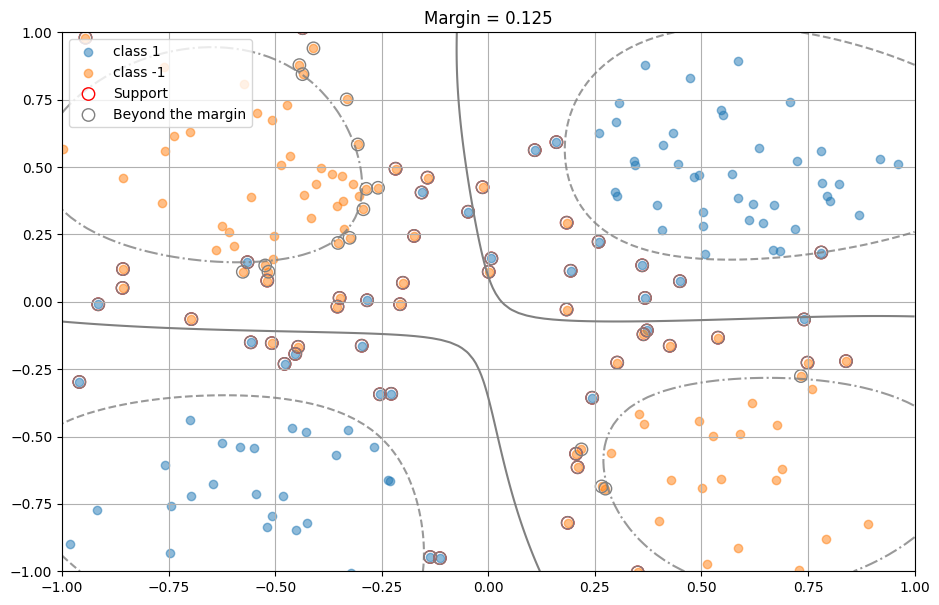

In [14]:
sigma = 0.5#TODO: provide a reasonalbe value
C= 1#TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-12)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

# Kernel Regression

## Loading the data

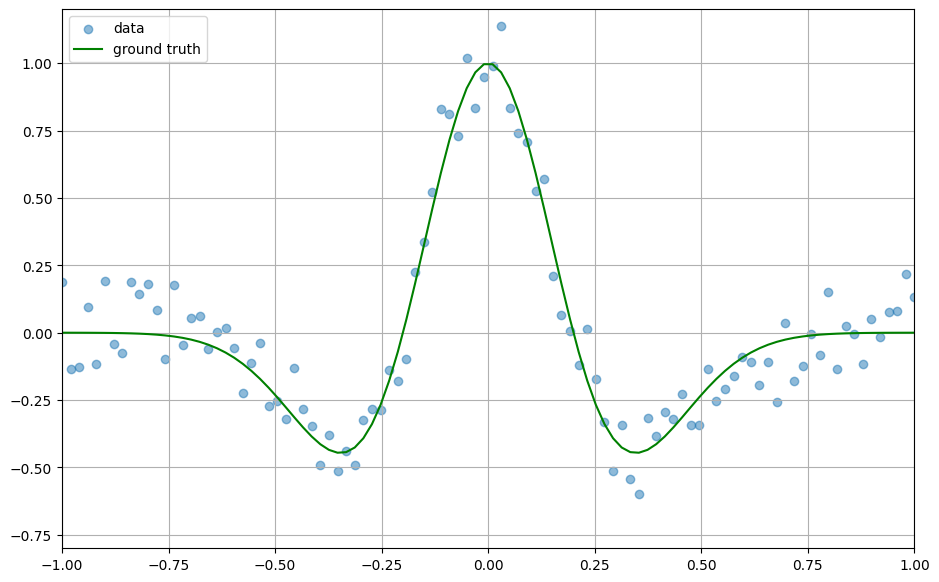

In [15]:
file = open('datasets/regression_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
train_set = datasets['dataset_1']['test']
plotRegression(train_set['x'], train_set['y'],Y_clean= train_set['y_clean'])


## Kernel Ridge Regression

### 0 - Questions:

First we use the representer theorem that tells us that the solution of the eq. 1 can be written $\hat{f}(x) = \sum_{i=1}^{N} \alpha_i K(x_i, x)$ for a certain $\alpha \in \mathbb{R}^N$. Then we notice that $(\hat{f}(x_i), ..., \hat{f}(x_N))^T = K\alpha$.

This gives us a new way of writing the problem : 


\begin{align*}
\underset{\alpha, b}{\min} \frac{1}{N}(K\alpha + b\mathbf{1}_N - y)^T(K\alpha + b\mathbf{1}_N - y) + \frac{\lambda}{2}\alpha^TK\alpha
\end{align*}


We can look at this problem as finding the optimal vector $v = (\alpha^*, b^*)$ and thus minimizing over $v$, by adding a column of ones to $K$ such that the resulting matrix $M$ verifies, $M(\alpha, b)^T = K\alpha + b\mathbf{1}_N$. We also need a matrix Q such that $v^TQv = \alpha^TK\alpha$ that will be the matrix $Q =
\begin{bmatrix}
K & 0_{N}\\
0_{N}^T& 0
\end{bmatrix}
$

In that case we have the problem (we multiply by $N$ just to make writting clearer): 


\begin{align*}
\underset{v}{\min} (Mv - y)^T(Mv - y) + \frac{N\lambda}{2}v^TQv
\end{align*}


In this case (since the objective is convex in v) we can compute the gradient in $v$ and find a closed form solution (let's write $g$ the objective function):


\begin{align*}
\nabla g(v) =  M^T(Mv - y) + \frac{N\lambda}{2}Qv = 0 \Leftrightarrow v = (M^TM + \frac{N\lambda}{2}Q)^{-1}M^Ty
\end{align*}




In the multivariate case we are looking for $q$ functions that each can be written (again thanks to the representer theorem) : $f_j(x) = \sum_{i=1}^{N} \alpha_{i,j}K(x_i,x)$. We also notice that the objective we must minimize is seperable for each function $f_j$ thus we actually solve $q$ univariate kernel ridge regression problems.

This is actually exactly the same formulation as the univariate case but the obtained solution $v$ is no longer a column vector but a $(N+1) \times q$ matrix where the first N columns of size $q$ correspond to the $\alpha_j = (\alpha_{i,j})_{i\in\{1,...,q\}}$ and the last column to the vector $b = (b_i)_{i\in\{1,...,q\}}$

The subtility here is that we don't like to invert large matrices, so to avoid that we will use np.linalg.solve method that solves efficiently equations of the form $Ax = b$.

Thinking of the algebraic complexity to solve this equation we can think of either solving directly $Ax = b$  or to use Cholesky where we decompose $A = LL^T$ and then solve in two steps 1) solve $Lu = b$ 2) solve $L^Tv = u$ this then gives us the solution $LL^Tv = L(L^Tv) = Lu = b$. 

In practice since the matrix $A$ is dependant on a regularization term I actually will not use Cholesky since it requires A to be definite positive and it is not always the case for certain $\lambda$.


### 1- Implementing the regressor
Implement the method 'fit' of the classes KernelRR and MultivariateKernelRR below to perform Kernel Ridge Regression. 


In [16]:
class KernelRR:
    
    def __init__(self,kernel,lmbda):
        self.lmbda = lmbda                    
        self.kernel = kernel    
        self.alpha = None 
        self.b = None
        self.support = None
        self.type='ridge'
        
    def fit(self, X, y):
        N = len(X)
        self.support = X
        self.K = self.kernel(X, X)
        
        M = np.hstack((self.K, np.ones((N,1))))
        Q = np.vstack((np.hstack((self.K, np.zeros((N, 1)))), np.zeros((1, N + 1))))

        #print(M.shape, Q.shape)
        #v = np.linalg.inv(M.T @ M + N * self.lmbda * Q / 2) @ M.T @ y

        A = M.T @ M + N * self.lmbda * Q / 2
        My =  M.T @ y

        v = np.linalg.solve(A, My)

        self.alpha = v[:-1]
        self.b = v[-1]
        
        
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x, self.support)
        return K @ self.alpha

    
    def predict(self, X):
        return self.regression_function(X) + self.b

    
class MultivariateKernelRR:      
    def __init__(self,kernel,lmbda, chol = False):
        self.lmbda = lmbda                    
        self.kernel = kernel
        self.support = None
        self.alpha = None
        self.b = None
        self.type='ridge'
        self.chol = chol
    
    def fit(self, X, y):
        self.support = X
        N = len(X)
        self.support = X
        self.K = self.kernel(X, X)
        
        M = np.hstack((self.K, np.ones((N,1))))
        Q = np.vstack((np.hstack((self.K, np.zeros((N, 1)))), np.zeros((1, N + 1))))

        A = M.T @ M + N * self.lmbda * Q / 2
        My =  M.T @ y

        if self.chol : 
            L = np.linalg.cholesky(A)  #A needs to be positive
            u = np.linalg.solve(L, My)
            v = np.linalg.solve(L.T, u)
        else:
            v = np.linalg.solve(A, My).astype(float)
        print(f"v : {v.shape}")
        self.alpha = v[:-1, :]
        self.b = v[-1, :]
        
    ### Implementation of the separting function $f$ 
    def regression_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(x, self.support)
        print(K.shape, self.alpha.shape)
        return K @ self.alpha
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        return self.regression_function(X)+np.expand_dims(self.b,axis=0)
    

### 2- Fitting the regressor

Run the code block below to fit the regressor and report its output.

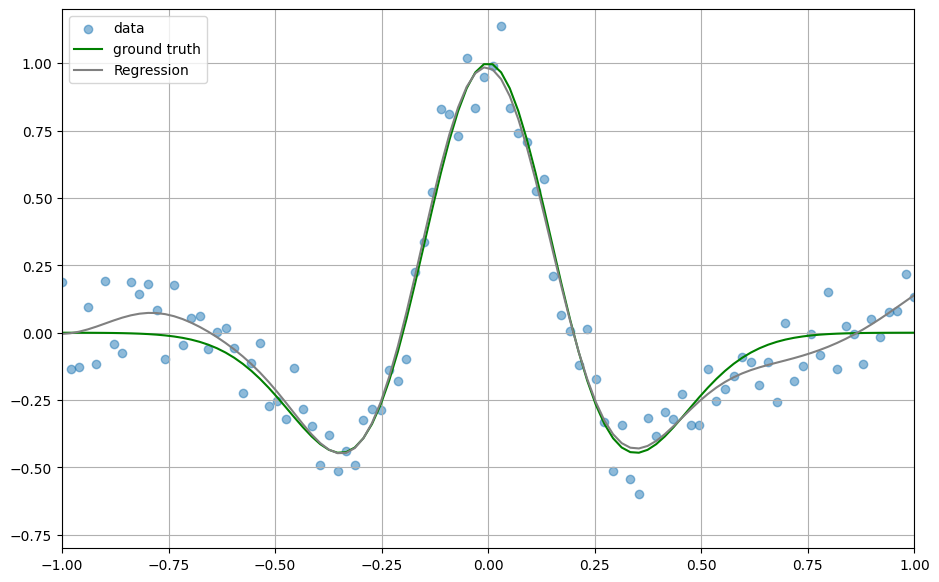

In [17]:
sigma = 0.2#TOO: provide a reasonable value
lmbda= 1e-3#TODO: provide a reasonable value
kernel = RBF(sigma).kernel
model = KernelRR(kernel, lmbda=lmbda)
model.fit(train_set['x'].reshape(-1,1),train_set['y'].reshape(-1,1))
plotRegression(train_set['x'], train_set['y'], Y_clean= train_set['y_clean'], model=model, label='Train')

We have a result close to the ground truth. This is a satisfying result.

# Kernel PCA

### 0- Questions :

First we would like to show that non-trivial eigenvectors of the Covariance operator $C$ have a nice form.
And we shall suppose that the data is centered in the RKHS : $\forall i, \; \tilde{\varphi}(x_i) = \varphi(x_i)$ where $\tilde{\varphi}(x_i) = \varphi(x_i) - \frac{1}{N}\sum_{j = 1}^{N} \varphi(x_j)$.

In this case we have :

\[
\begin{align}
Cv = \lambda v &\Longleftrightarrow \frac{1}{N} \sum_{i = 1}^{N} \left(\tilde{\varphi} \otimes \tilde{\varphi}(x_i)\right)v = \lambda v\\
               &\Longleftrightarrow \frac{1}{N} \sum_{i = 1}^{N} <\tilde{\varphi}(x_i), v> \tilde{\varphi}(x_i) = \lambda v\\
               &\Longleftrightarrow  \sum_{i = 1}^{N} \frac{1}{\lambda N}<\tilde{\varphi}(x_i), v> \tilde{\varphi}(x_i) = v\\
               &\Longleftrightarrow v = \sum_{i=1}^{N} \alpha_i \tilde{\varphi}(x_i)
\end{align}
\]

We then project along each $\tilde{\varphi}(x_l)$ and use the second and last lines above: 



\[
\begin{align*}
\frac{1}{N} \sum_{i = 1}^{N} <\tilde{\varphi}(x_i), \sum_{j=1}^{N} \alpha_j \tilde{\varphi}(x_j)><\tilde{\varphi}(x_i),\tilde{\varphi}(x_l)> &= \lambda \sum_{j=1}^{N} \alpha_j <\tilde{\varphi}(x_j),\tilde{\varphi}(x_l)>\\
\Longleftrightarrow \frac{1}{N} \sum_{i = 1}^{N} <\tilde{\varphi}(x_i),\tilde{\varphi}(x_l)> \sum_{j=1}^{N} \alpha_j <\tilde{\varphi}(x_i),  \tilde{\varphi}(x_j)> &= \lambda \sum_{j=1}^{N} \alpha_j <\tilde{\varphi}(x_j),\tilde{\varphi}(x_l)>
\end{align*}
\]

Since the data are centered in the RKHS we recognize exactly the Kernel evaluation (we write in matrix form):

\[
\begin{align*}
\frac{1}{N} \sum_{i = 1}^{N} K(x_i, x_l) \sum_{j=1}^{N} \alpha_j K(x_i, x_j) &= \lambda \sum_{j=1}^{N} \alpha_j K(x_i, x_l)\\
\frac{1}{N} \sum_{i = 1}^{N} K(x_i, x_l) (K \alpha)_l &= \lambda (K \alpha)_l\\
\frac{1}{N} (K(K \alpha))_l &= \lambda (K \alpha)_l\\
\end{align*}
\]

And this for all $l$, so we have (after removing a $K$), $\frac{1}{N} K \alpha = \lambda \alpha$, thus $\alpha$ is an eigenvector of the Gram matrix $K$.

But don't forget this is true in the case were $\frac{1}{N}\sum_{j = 1}^{N} \varphi(x_j) = 0$

So we consider another Kernel matrix that verifies the wanted equality : $\tilde{K}(x_i, x_j) = <\tilde{\varphi}(x),\tilde{\varphi}(y) > = <\varphi(x_i),\varphi(y) > -\frac{1}{N}\sum_{k=1}^{N}<\varphi(x_k), \varphi(x_i)+\varphi(x_j)> + \frac{1}{N^2}\sum_{k,l=1}^{N}<\varphi(x_k),\varphi(x_l)>$

We thus consider the matrix $\tilde{K} = K - 1_NK - K1_N + 1_N K 1_N$ where $1_N$ is an $N\times N$ matrix containing only $\frac{1}{N}$. We then have the ability to write what was above with this matrix :

\[
\begin{align}
\frac{1}{N} \tilde{K} \alpha = \lambda \alpha
\end{align}
\]

So to solve PCA we first find the eigenvectors of $\tilde{K}$, then we have an expression for $v_i = \sum_{j = 1}^{N}\alpha^i_j \tilde{K}(x_i, x_j)$. This is equivalent to applying the transformation $Y = KA$ where $A =(\alpha^i)_i$.

We will also add the possibility to choose the principal compenents on which we would like to project.

### 1- Implementing kernel PCA
Implement the method 'fit' of the classes KernelSVR below to perform Kernel Support Vector Regression. 

In [57]:



class KernelPCA:
    
    def __init__(self,kernel, r=2, normalize = False):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r = r ## Number of principal components
        self.normalize = normalize
    def compute_PCA(self, X, indices=None):
        # assigns the vectors
        self.support = X
        N = len(X)
        K = self.kernel(X,X)
        if self.normalize:
            U = np.ones(K.shape) / N
            K = K - U @ K - K @ U + U @ K @ U
        
        eigenvalues, eigenvectors = np.linalg.eig(K / N)
        self.K = K
        if indices is not None:
            self.lmbda = eigenvalues[indices]
            self.alpha = eigenvectors[:, indices] #the wanted eigenvectors
        else:
            self.lmbda = eigenvalues[:self.r]
            self.alpha = eigenvectors[:, :self.r] #first r eigenvectors of K
        
        self.lmbda = np.real(self.lmbda)
        self.alpha = np.real(self.alpha)

    
    def transform(self, x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        
        return self.kernel(x, self.support) @ self.alpha
    


### 2- Performing kernel PCA

Run the code block below apply a kernel PCA to a dataset consisting of three concentric rings and report the output. What can you conclude about this dataset?

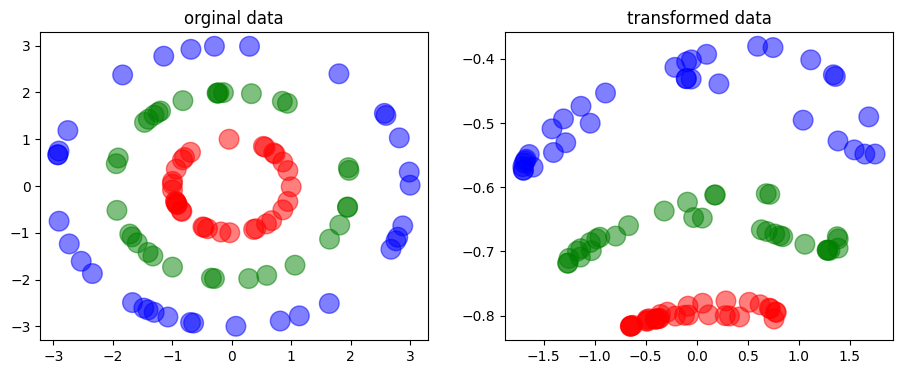

In [58]:
file = open('datasets/pca_datasets', 'rb')
datasets = pkl.load(file)
file.close()
train_set = datasets['dataset_1']['train']
test_set = datasets['dataset_1']['test']

sigma = 4
kernel = RBF(sigma).kernel
pca = KernelPCA(kernel, r=2, normalize = True)
pca.compute_PCA(train_set['x'], [1,2])
pca_components = pca.transform(test_set['x'])

fig, ax = plt.subplots(1,2, figsize=(11, 4))
scatter_label_points(test_set['x'], test_set['y'], ax[0], title='orginal data')
scatter_label_points(pca_components,test_set['y'], ax[1], title= 'transformed data')




We have successfully seperated the data points ! To do so we had to bypass the first principle component and use the 2nd and 3rd ones. It is as if the data points live on a cone and we have just changed the orientation of the view. This shows us that seperating data is not always the same as finding the components that better explain the variance in the data (the 1st component). Since we are passing from 2D to 2D we have this fealing of change of orientation, this is less visible for higher dimensional data. What is interesting is to know this trick, and I believe doing PCA (to 2D or 3D space) properly is a trial and error method where we try out different components and look at the results. 

Since the data is circular and each class described by some form of radius, the PCA captured this information and our new "y" values depend on the magnitude of the radius of the points (central points have smaller "y" values). The "x" values seem the same. 

# Denoising 
### 1- Implementing a denoiser based on Kernel PCA and Kernel Ridge Regression
Implement the methods 'fit' and 'denoise' of the classes Denoiser below. 

The first idea I had was the following : 
>First project with PCA the noisy images in a smaller dimensional space, and then train a regressor to map a point from this smaller dimensional space to the set of (close to) clean images.

But this did not work well in practice even if I liked the idea. 

I then tried out only using the noisy images, this is how sklearn does it in their example at : https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html. They rely on the fact that PCA "forgets"/"neglects" the noise by reducing dimensionality and when using ridge regression it returns smoothed and less noisy images.


The denoising was better on the train set for my suggestion but I was unable to make it work on the test set.

In [86]:
class Denoiser:
    def __init__(self, kernel_encoder, kernel_decoder,dim_pca, lmbda):
        self.pca = KernelPCA(kernel_encoder, r=dim_pca, normalize=True)
        self.ridge_reg = MultivariateKernelRR(kernel_decoder, lmbda= lmbda)
    
    def fit(self, train, use_clean = False):
        noisy, clean = train

        #apply kernel PCA on noisy data
        self.pca.compute_PCA(noisy)           
        pca_components = self.pca.transform(noisy)
        print("encoder trained")

        #decode the noisy projected data to match the clean data
        if use_clean:
            self.ridge_reg.fit(pca_components, clean)
        else:
            self.ridge_reg.fit(pca_components, noisy)
        print("decoder trained")
        
    def denoise(self, test):
        pca_components = self.pca.transform(test)        
        return self.ridge_reg.predict(pca_components)

def psnr(clean,pred,M=1): #compute PSNR
    rmse = np.sqrt(np.mean((np.array(clean)-np.array(pred))**2))
    return 20*np.log10(M/rmse)

### 2- Denoising MNIST dataset

Run the code block below to perform denoising of a subset of MNIST digits dataset and report the output. To what extend the denoising is successful? How can it be improved?


First let's train the model and check it's performance on the training set.

encoder trained
v : (2001, 784)
decoder trained
(2000, 2000) (2000, 784)


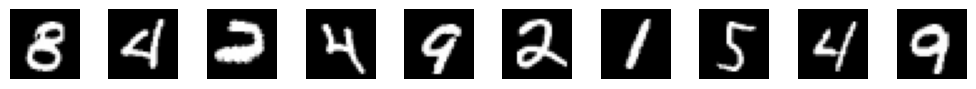

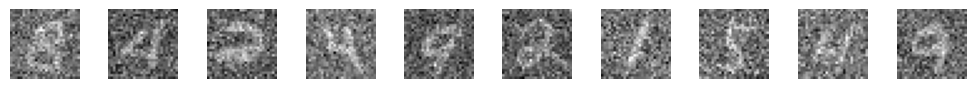

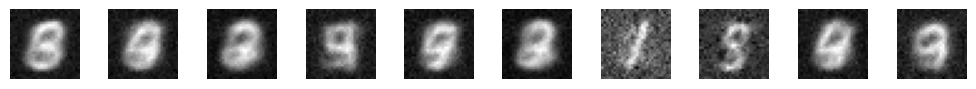

The mean PSNR is : 13.450259382430447


In [87]:
datasets = loadMNIST('datasets/SubsetMNIST')
clean_data = datasets['cleanMNIST']
data = datasets['noisyMNIST']

dim_pca = 80
lmbda = 1e-4
sigma_encoder = 1e2
sigma_decoder = 1e1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit((data["train"].reshape(-1, 28*28), clean_data["train"].reshape(-1, 28*28)))
pred = denoiser.denoise(data["train"].reshape(-1, 28*28)).reshape(-1, 28, 28)

idx = np.arange(len(pred))
np.random.shuffle(idx)

plot_multiple_images(clean_data['train'][idx])
plot_multiple_images(data['train'][idx])
plot_multiple_images(pred[idx])
print(f"The mean PSNR is : {psnr(clean_data['train'],pred,M=1)}")

As we can see we are able to remove the background noise and make smooth predictions on the training set.

Let's try it out on the test set.

(2000, 2000) (2000, 784)


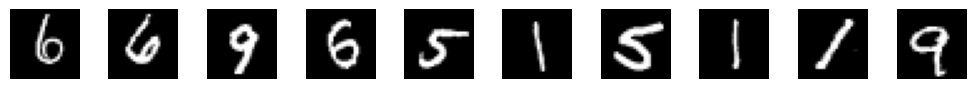

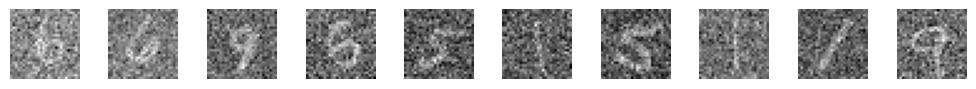

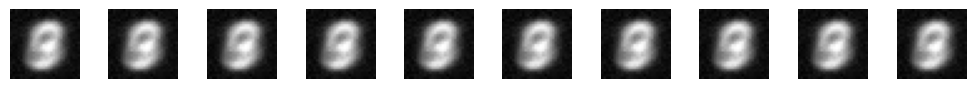

The mean PSNR is : 11.758603807581963


In [88]:
pred = denoiser.denoise(data["test"].reshape(-1, 28*28)).reshape(-1, 28, 28) #denoising phase

idx = np.arange(len(pred))
np.random.shuffle(idx)

plot_multiple_images(clean_data['test'][idx])
plot_multiple_images(data['test'][idx])
plot_multiple_images(pred[idx])
print(f"The mean PSNR is : {psnr(clean_data['train'],pred,M=1)}")

As we can see this looks like the denoiser overfitted to the training set and is unable to generalize, we need to change the parameters especially the regression.

encoder trained
v : (2001, 784)
decoder trained
(2000, 2000) (2000, 784)


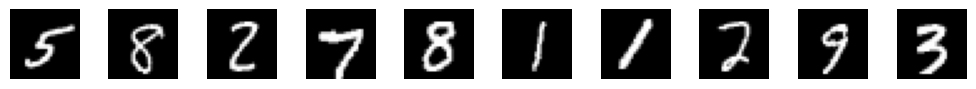

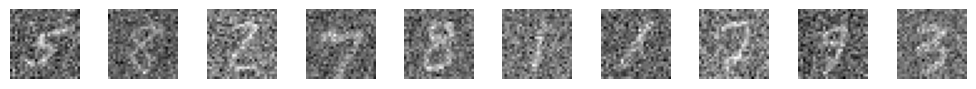

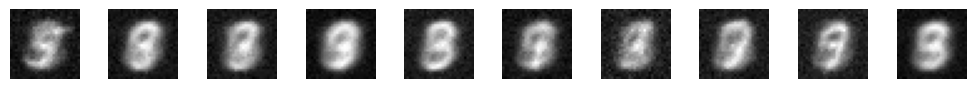

The mean PSNR is : 12.327167456832628
(2000, 2000) (2000, 784)


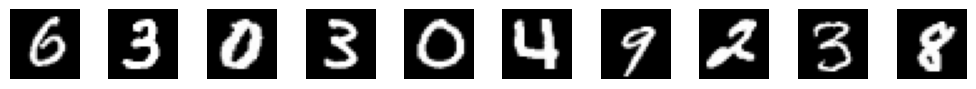

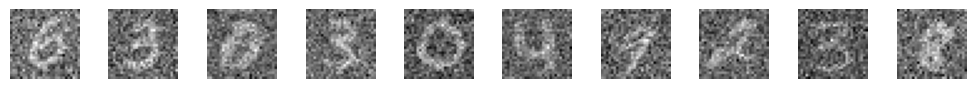

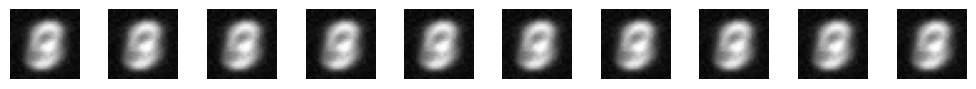

The mean PSNR is : 11.758653730978718


In [89]:
dim_pca = 80
lmbda = 5e-4
sigma_encoder = 1e1
sigma_decoder = 1e1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit((data["train"].reshape(-1, 28*28), clean_data["train"].reshape(-1, 28*28)))
pred = denoiser.denoise(data["train"].reshape(-1, 28*28)).reshape(-1, 28, 28)

idx = np.arange(len(pred))
np.random.shuffle(idx)

plot_multiple_images(clean_data['train'][idx])
plot_multiple_images(data['train'][idx])
plot_multiple_images(pred[idx])
print(f"The mean PSNR is : {psnr(clean_data['train'],pred,M=1)}")

pred = denoiser.denoise(data["test"].reshape(-1, 28*28)).reshape(-1, 28, 28) #denoising phase

idx = np.arange(len(pred))
np.random.shuffle(idx)

plot_multiple_images(clean_data['test'][idx])
plot_multiple_images(data['test'][idx])
plot_multiple_images(pred[idx])
print(f"The mean PSNR is : {psnr(clean_data['train'],pred,M=1)}")

The biggest difficulty is to find the appropriate hyperparameters. And after trying a $\textbf{lot}$ of different parameters I was unable to find the appropriate ones. Either it is not reguralized enough and thus it generates always the same image on the test set, either it is reguralized too much and doesn't perform well on the training set either. Let's try something out to see if these images are really all the same.

(3, 2000) (2000, 784)


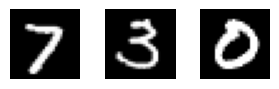

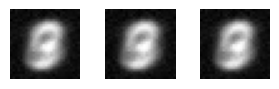

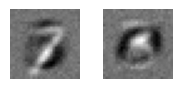

In [90]:
pred = denoiser.denoise(data["test"][:3].reshape(-1, 28*28)).reshape(-1, 28, 28) #denoising phase
plot_multiple_images(clean_data['test'][:3], num_col=3)
plot_multiple_images(pred[:3], num_col=3)
plot_multiple_images(pred[:2] - pred[1:3], num_col=2)


Actually as we can see when doing pairwise differences of the "denoised" images they aren't all the same (images are not all black) but what is interesting is actually that these images do contain information about them. We can see that the denoising of the "7" minus the denoising of the "3" gives us a combination of a 7 (in white) and of a 3 (in black), same for "3" and "0". 

So the denoising works to some extent, now I believe that the work is to find the correct hyperparameters, but I was unable to do so.

Here is an example with my suggestion :

encoder trained
v : (2001, 784)
decoder trained
(2000, 2000) (2000, 784)


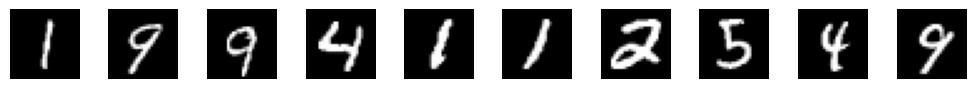

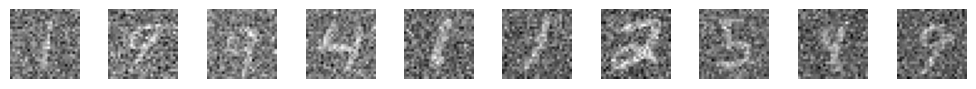

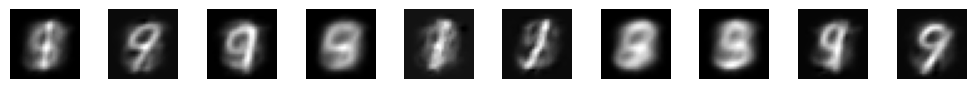

The mean PSNR is : 13.524403952349527
(2000, 2000) (2000, 784)


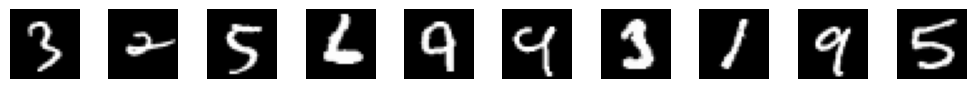

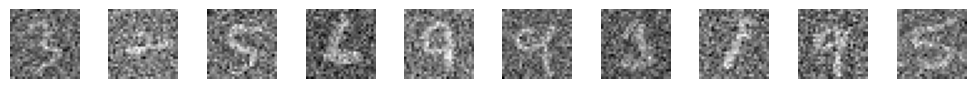

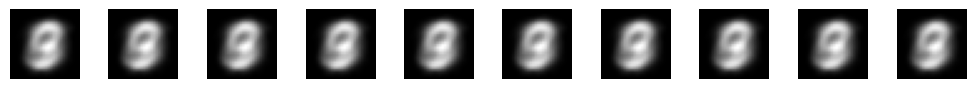

The mean PSNR is : 11.766832945922683


In [93]:
dim_pca = 80
lmbda = 1e-4
sigma_encoder = 1e1
sigma_decoder = 1e1
kernel_encoder = RBF(sigma_encoder).kernel
kernel_decoder = RBF(sigma_decoder).kernel
denoiser = Denoiser(kernel_encoder,kernel_decoder,dim_pca, lmbda)

denoiser.fit((data["train"].reshape(-1, 28*28), clean_data["train"].reshape(-1, 28*28)), use_clean = True)
pred = denoiser.denoise(data["train"].reshape(-1, 28*28)).reshape(-1, 28, 28)

idx = np.arange(len(pred))
np.random.shuffle(idx)

plot_multiple_images(clean_data['train'][idx])
plot_multiple_images(data['train'][idx])
plot_multiple_images(pred[idx])
print(f"The mean PSNR is : {psnr(clean_data['train'],pred,M=1)}")

pred = denoiser.denoise(data["test"].reshape(-1, 28*28)).reshape(-1, 28, 28) #denoising phase

idx = np.arange(len(pred))
np.random.shuffle(idx)

plot_multiple_images(clean_data['test'][idx])
plot_multiple_images(data['test'][idx])
plot_multiple_images(pred[idx])
print(f"The mean PSNR is : {psnr(clean_data['train'],pred,M=1)}")